# Netflix Appetency for Identifying consumer willing to subscribe

-------------------------
This code is for classifying consumers according to their appetite to subscribe to Netflix.

![Image](https://play-lh.googleusercontent.com/0rgPYj0GwZ6txpYZrzoMdhwzqg7vY6C9B-Ol7jlaz-Ox2rgpD4Tr82ZgDqkirrEohbGm)

Data:
* train.csv - the training set. it consists of an id column, the customers features, and a target column: target.
* test.csv - the test set. it consists of everything in train.csv except target.
* sample_submission.csv  - a sample submission file in the correct format target=1 means that the customer subscribes to Netflix

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/netflix-appetency/sample_submission.csv
/kaggle/input/netflix-appetency/train.csv
/kaggle/input/netflix-appetency/test.csv


In [6]:
!pip install optuna-integration[lightgbm] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
import optuna
from optuna.integration import LightGBMPruningCallback
import gc
from itertools import cycle

from random import choice, choices
pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

import warnings
warnings.filterwarnings('ignore')

In [8]:
train_df = pd.read_csv("../input/netflix-appetency/train.csv")
test_df = pd.read_csv("../input/netflix-appetency/test.csv")
ss_df = pd.read_csv("../input/netflix-appetency/sample_submission.csv")
train_df.shape, test_df.shape, ss_df.shape

((70000, 509), (30000, 508), (30000, 2))

In [ ]:
countna_df = train_df.isnull().sum().sort_values(ascending=False).to_frame().T
null_columns = countna_df[countna_df >= 42000].dropna(axis=1).columns.to_list()
print(f'Null Columns: {null_columns}')

train_df = train_df.drop(columns=null_columns)
test_df = test_df.drop(columns=null_columns)

train_df.shape, test_df.shape

In [10]:
pd.set_option('display.max_columns', None)  
display(train_df.head())
display(test_df.head())

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_194,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,fe

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_194,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_3

In [11]:
# feature_191' ~ 'feature_204' are date_columns
dd_cols = ['feature_191', 'feature_192', 'feature_194', 'feature_195', 'feature_199', 'feature_200', 'feature_201', 'feature_202', 'feature_203', 'feature_204']
date_columns = [col for col in dd_cols if col in train_df.columns.tolist()]

for column in date_columns:
    train_df[column] = pd.to_datetime(train_df[column],format='%d/%m/%Y', errors='coerce')
    test_df[column] = pd.to_datetime(test_df[column],format='%d/%m/%Y', errors='coerce')
    
    train_df[column+'_year'] = train_df[column].dt.year.astype(str)
    test_df[column+'_year'] = test_df[column].dt.year.astype(str)
    train_df[column+'_month'] = train_df[column].dt.month.astype(str)
    test_df[column+'_month'] = test_df[column].dt.month.astype(str)
    train_df[column+'_day'] = train_df[column].dt.day.astype(str)
    test_df[column+'_day'] = test_df[column].dt.day.astype(str)
    
    train_df[column+'_isWeekend'] = np.where(train_df[column].dt.weekday>=5, 'Weekend', 'Weekday') # Monday is 0, Sat, Sun is 5, 6
    test_df[column+'_isWeekend'] = np.where(test_df[column].dt.weekday>=5, 'Weekend', 'Weekday')
    
    train_df = train_df.drop(column, axis=1)
    test_df = test_df.drop(column, axis=1)

train_df.shape, test_df.shape

((70000, 519), (30000, 518))

In [12]:
display(train_df.head())
display(test_df.head())

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,fe

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_3

In [13]:
nunique_cat_df = train_df.select_dtypes('object').nunique().sort_values().to_frame().T
display(nunique_cat_df)

,feature_190,feature_187,feature_188,feature_249,feature_248,feature_55,feature_33,feature_0,feature_27,feature_337,feature_338,feature_371,feature_202_isWeekend,feature_1,feature_204_isWeekend,feature_32,feature_200_isWeekend,feature_277,feature_28,feature_152,feature_336,feature_199_isWeekend,feature_242,feature_239,feature_250,feature_41,feature_270,feature_34,feature_278,feature_192_isWeekend,feature_194_isWeekend,feature_201_isWeekend,feature_30,feature_42,feature_191_isWeekend,feature_29,feature_23,feature_31,feature_203_isWeekend,feature_241,feature_240,feature_286,feature_134,feature_276,feature_164,feature_163,feature_16,feature_244,feature_58,feature_285,feature_275,feature_251,feature_284,feature_2,feature_3,feature_293,feature_292,feature_283,feature_205,feature_291,feature_199_year,feature_199_month,feature_165,feature_4,feature_186,feature_135,feature_200_month,feature_191_month,feature_192_month,feature_203_month,feature_204_month,feature_202_month,feature_201_month,feature_194_year,feature_194_month,feature_203_year,feature_243,feature_201_year,feature_202_year,feature_192_year,feature_204_year,feature_200_year,feature_274,feature_189,feature_282,feature_290,feature_191_year,feature_24,feature_97,feature_273,feature_199_day,feature_203_day,feature_204_day,feature_194_day,feature_192_day,feature_191_day,feature_202_day,feature_201_day,feature_200_day,feature_281,feature_289,feature_272,feature_271,feature_247,feature_17,feature_280,feature_288,feature_287,feature_279,feature_246,feature_185,feature_19,feature_54,feature_21,feature_22,feature_20,feature_133,feature_18
0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,6,6,6,6,6,6,7,9,10,10,11,12,12,12,13,13,13,13,13,13,13,13,13,13,13,14,15,15,16,16,17,17,17,21,21,22,24,25,29,30,31,32,32,32,32,32,32,32,32,37,40,75,82,86,103,111,116,135,136,147,255,260,260,2327,2339,5841,7126,15858


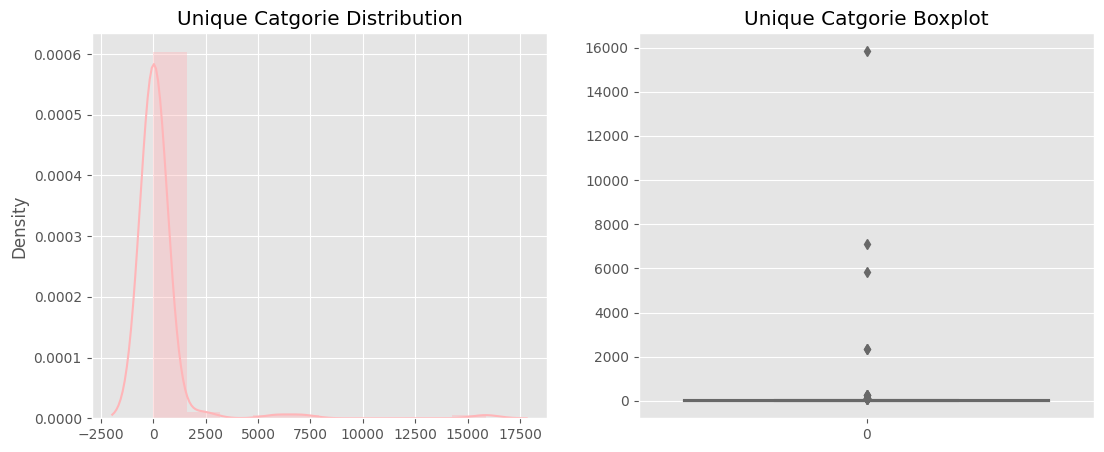

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.distplot(nunique_cat_df.values, bins=10, color=choice(color_pal), label='time_id')
plt.title("Unique Catgorie Distribution")

plt.subplot(132)
sns.boxplot(nunique_cat_df.values, color=choice(color_pal))
plt.title("Unique Catgorie Boxplot")


plt.show()

In [15]:
single_feature_columns = nunique_cat_df[nunique_cat_df <= 1].dropna(axis=1).columns.to_list()
print(f'Single Feature Columns: {single_feature_columns}\n')

train_df = train_df.drop(columns=single_feature_columns)
test_df = test_df.drop(columns=single_feature_columns)

more_cat_feature_columns = nunique_cat_df[nunique_cat_df >= 256].dropna(axis=1).columns.to_list()
print(f'256+ Feature Columns: {more_cat_feature_columns}\n')

train_df = train_df.drop(columns=more_cat_feature_columns)
test_df = test_df.drop(columns=more_cat_feature_columns)

train_df.shape, test_df.shape

Single Feature Columns: ['feature_190', 'feature_187', 'feature_188', 'feature_249', 'feature_248', 'feature_55']

256+ Feature Columns: ['feature_19', 'feature_54', 'feature_21', 'feature_22', 'feature_20', 'feature_133', 'feature_18']



((70000, 506), (30000, 505))

In [16]:
cat_columns = [col for col in train_df.select_dtypes('object').columns]
train_df[cat_columns].head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_58,feature_97,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_189,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371,feature_191_year,feature_191_month,feature_191_day,feature_191_isWeekend,feature_192_year,feature_192_month,feature_192_day,feature_192_isWeekend,feature_194_year,feature_194_month,feature_194_day,feature_194_isWeekend,feature_199_year,feature_199_month,feature_199_day,feature_199_isWeekend,feature_200_year,feature_200_month,feature_200_day,feature_200_isWeekend,feature_201_year,feature_201_month,feature_201_day,feature_201_isWeekend,feature_202_year,feature_202_month,feature_202_day,feature_202_isWeekend,feature_203_year,feature_203_month,feature_203_day,feature_203_isWeekend,feature_204_year,feature_204_month,feature_204_day,feature_204_isWeekend
0,C0,C0,C1,C5,C11,C0,C60,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C4,C41,C2,C16,C0,C1,C1,C2,C1483,C6,C20,C5,C0,C1,C1,C1,C0,C2,C140,C91,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0,2017.0,10.0,11.0,Weekday,2017.0,10.0,11.0,Weekday,2017.0,11.0,9.0,Weekday,2017,10,11,Weekday,nan,nan,nan,Weekday,2017.0,10.0,11.0,Weekday,nan,nan,nan,Weekday,nan,nan,nan,Weekday,nan,nan,nan,Weekday
1,C0,C0,C3,C5,C1,C2,C50,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C11,C1483,C8,C21,C9,C0,C2,C2,C1,C14,C3,C193,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0,2015.0,3.0,25.0,Weekday,2015.0,3.0,25.0,Weekday,nan,nan,nan,Weekday,2017,4,2,Weekend,2015.0,3.0,25.0,Weekday,2015.0,3.0,25.0,Weekday,nan,nan,nan,Weekday,nan,nan,nan,Weekday,2015.0,3.0,25.0,Weekday
2,C0,C0,C3,C5,C2,C1,C76,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C11,C1483,C4,C11,C9,C0,C2,C2,C1,C14,C3,C175,C66,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0,2015.0,1.0,27.0,Weekday,2015.0,1.0,27.0,Weekday,2017.0,5.0,13.0,Weekend,2016,3,24,Weekday,2015.0,1.0,27.0,Weekday,2015.0,1.0,27.0,Weekday,nan,nan,nan,Weekday,nan,nan,nan,Weekday,2015.0,1.0,27.0,Weekday
3,C0,C0,C1,C5,C1,C0,C58,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C7,C41,C2,C16,C0,C3,C1,C1,C1483,C2,C5,C0,C0,C2,C2,C1,C0,C3,C193,C13,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0,2014.0,2.0,5.0,Weekday,2014.0,4.0,1.0,Weekday,nan,nan,nan,Weekday,2014,4,1,Weekday,2014.0,4.0,1.0,Weekday,2014.0,4.0,1.0,Weekday,2014.0,3.0,31.0,Weekday,2014.0,3.0,31.0,Weekday,2014.0,2.0,5.0,Weekday
4,C0,C0,C3,C3,C11,C2,C48,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C5,C1,C2,C16,C0,C0,C1,C11,C1483,C12,C11,C2,C0,C1,C1,C1,C0,C2,C60,C31,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1,2009.0,7.0,20.0,Weekday,2013.0,9.0,10.0,Weekday,2017.0,2.0,14.0,Weekday,2013,9,10,Weekday,2016.0,1.0,24.0,Weekend,2013.0,9.0,10.0,Weekday,2016.0,1.0,24.0,Weekend,2013.0,9.0,10.0,Weekday,2011.0,3.0,23.0,Weekday


In [17]:
train_df.select_dtypes(['int', 'float']).head()

,id,target,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,featu

In [18]:
target_column = 'target'
drop_columns = ['id', target_column]

num_columns = [col for col in train_df.select_dtypes(['int', 'float']).columns if col not in drop_columns]
train_df[num_columns].head()

,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_385,feature_386,feature_387,feature_388,feature_389,feature_390,feature_391,feature_392,feature_393,feature_394,feature_395,feature_396,feature_397,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_405,feature_406,feature_407,feature_408,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418,feature_419,feature_420,feature_421,feature_422,feature_423,feature_424,feature_425,feature_426,feature_427,feature_428,feature_429,feature_430,feature_431,feature_432,feature_433,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_445,fea

In [19]:
nunique_num_df = train_df[num_columns].nunique().sort_values().to_frame().T
nunique_num_df

,feature_100,feature_482,feature_484,feature_487,feature_489,feature_474,feature_476,feature_478,feature_480,feature_467,feature_469,feature_472,feature_252,feature_312,feature_313,feature_358,feature_445,feature_449,feature_451,feature_397,feature_227,feature_228,feature_357,feature_385,feature_389,feature_395,feature_453,feature_455,feature_459,feature_461,feature_375,feature_377,feature_463,feature_465,feature_432,feature_433,feature_149,feature_421,feature_425,feature_427,feature_409,feature_411,feature_412,feature_413,feature_419,feature_405,feature_498,feature_505,feature_502,feature_500,feature_491,feature_493,feature_495,feature_311,feature_497,feature_504,feature_503,feature_501,feature_77,feature_126,feature_98,feature_99,feature_492,feature_494,feature_496,feature_136,feature_138,feature_475,feature_477,feature_410,feature_418,feature_107,feature_444,feature_120,feature_123,feature_420,feature_51,feature_468,feature_471,feature_473,feature_47,feature_50,feature_424,feature_426,feature_146,feature_299,feature_499,feature_263,feature_265,feature_267,feature_294,feature_148,feature_464,feature_466,feature_112,feature_113,feature_330,feature_332,feature_333,feature_261,feature_373,feature_374,feature_376,feature_454,feature_458,feature_460,feature_462,feature_384,feature_388,feature_394,feature_396,feature_323,feature_324,feature_325,feature_326,feature_327,feature_329,feature_448,feature_450,feature_452,feature_315,feature_316,feature_317,feature_319,feature_307,feature_479,feature_481,feature_483,feature_485,feature_486,feature_488,feature_404,feature_408,feature_102,feature_103,feature_506,feature_490,feature_101,feature_124,feature_125,feature_304,feature_305,feature_306,feature_104,feature_105,feature_106,feature_108,feature_109,feature_110,feature_143,feature_144,feature_335,feature_303,feature_322,feature_328,feature_393,feature_151,feature_372,feature_331,feature_334,feature_245,feature_111,feature_115,feature_150,feature_295,feature_296,feature_297,feature_53,feature_470,feature_117,feature_118,feature_119,feature_121,feature_122,feature_298,feature_300,feature_301,feature_302,feature_147,feature_43,feature_44,feature_45,feature_46,feature_48,feature_49,feature_52,feature_145,feature_116,feature_127,feature_137,feature_139,feature_140,feature_141,feature_142,feature_308,feature_309,feature_310,feature_314,feature_318,feature_320,feature_321,feature_422,feature_392,feature_78,feature_446,feature_447,feature_423,feature_430,feature_69,feature_398,feature_264,feature_431,feature_399,feature_266,feature_268,feature_262,feature_79,feature_386,feature_414,feature_254,feature_378,feature_434,feature_390,feature_406,feature_416,feature_114,feature_456,feature_436,feature_428,feature_382,feature_369,feature_442,feature_380,feature_400,feature_402,feature_440,feature_71,feature_438,feature_67,feature_407,feature_383,feature_269,feature_439,feature_255,feature_443,feature_415,feature_457,feature_429,feature_391,feature_403,feature_435,feature_381,feature_379,feature_417,feature_370,feature_441,feature_387,feature_437,feature_401,feature_62,feature_72,feature_73,feature_70,feature_80,feature_87,feature_128,feature_130,feature_129,feature_68,feature_166,feature_63,feature_363,feature_367,feature_64,feature_341,feature_355,feature_359,feature_339,feature_59,feature_361,feature_74,feature_170,feature_56,feature_343,feature_347,feature_365,feature_57,feature_342,feature_176,feature_364,feature_82,feature_345,feature_253,feature_368,feature_340,feature_356,feature_351,feature_360,feature_349,feature_60,feature_61,feature_175,feature_353,feature_81,feature_362,feature_171,feature_181,feature_211,feature_167,feature_344,feature_348,feature_366,feature_65,feature_173,feature_346,feature_85,feature_352,feature_90,feature_180,feature_233,feature_350,feature_209,feature_237,feature_212,feature_177,feature_84,feature_88,feature_257,feature_256,feature_354,feature_210,feature_229,feature_178,feature_168,feature_66,feature_234,feature_2

In [20]:
single_feature_columns = nunique_num_df[nunique_num_df<=1].dropna(axis=1).columns.to_list()
print(f'Single Feature Columns: {single_feature_columns}\n')

train_df = train_df.drop(columns=single_feature_columns)
test_df = test_df.drop(columns=single_feature_columns)

train_df.shape, test_df.shape

Single Feature Columns: ['feature_100', 'feature_482', 'feature_484', 'feature_487', 'feature_489', 'feature_474', 'feature_476', 'feature_478', 'feature_480', 'feature_467', 'feature_469', 'feature_472', 'feature_252', 'feature_312', 'feature_313', 'feature_358', 'feature_445', 'feature_449', 'feature_451', 'feature_397', 'feature_227', 'feature_228', 'feature_357', 'feature_385', 'feature_389', 'feature_395', 'feature_453', 'feature_455', 'feature_459', 'feature_461', 'feature_375', 'feature_377', 'feature_463', 'feature_465', 'feature_432', 'feature_433', 'feature_149', 'feature_421', 'feature_425', 'feature_427', 'feature_409', 'feature_411', 'feature_412', 'feature_413', 'feature_419', 'feature_405', 'feature_498', 'feature_505', 'feature_502', 'feature_500', 'feature_491', 'feature_493', 'feature_495']



((70000, 453), (30000, 452))

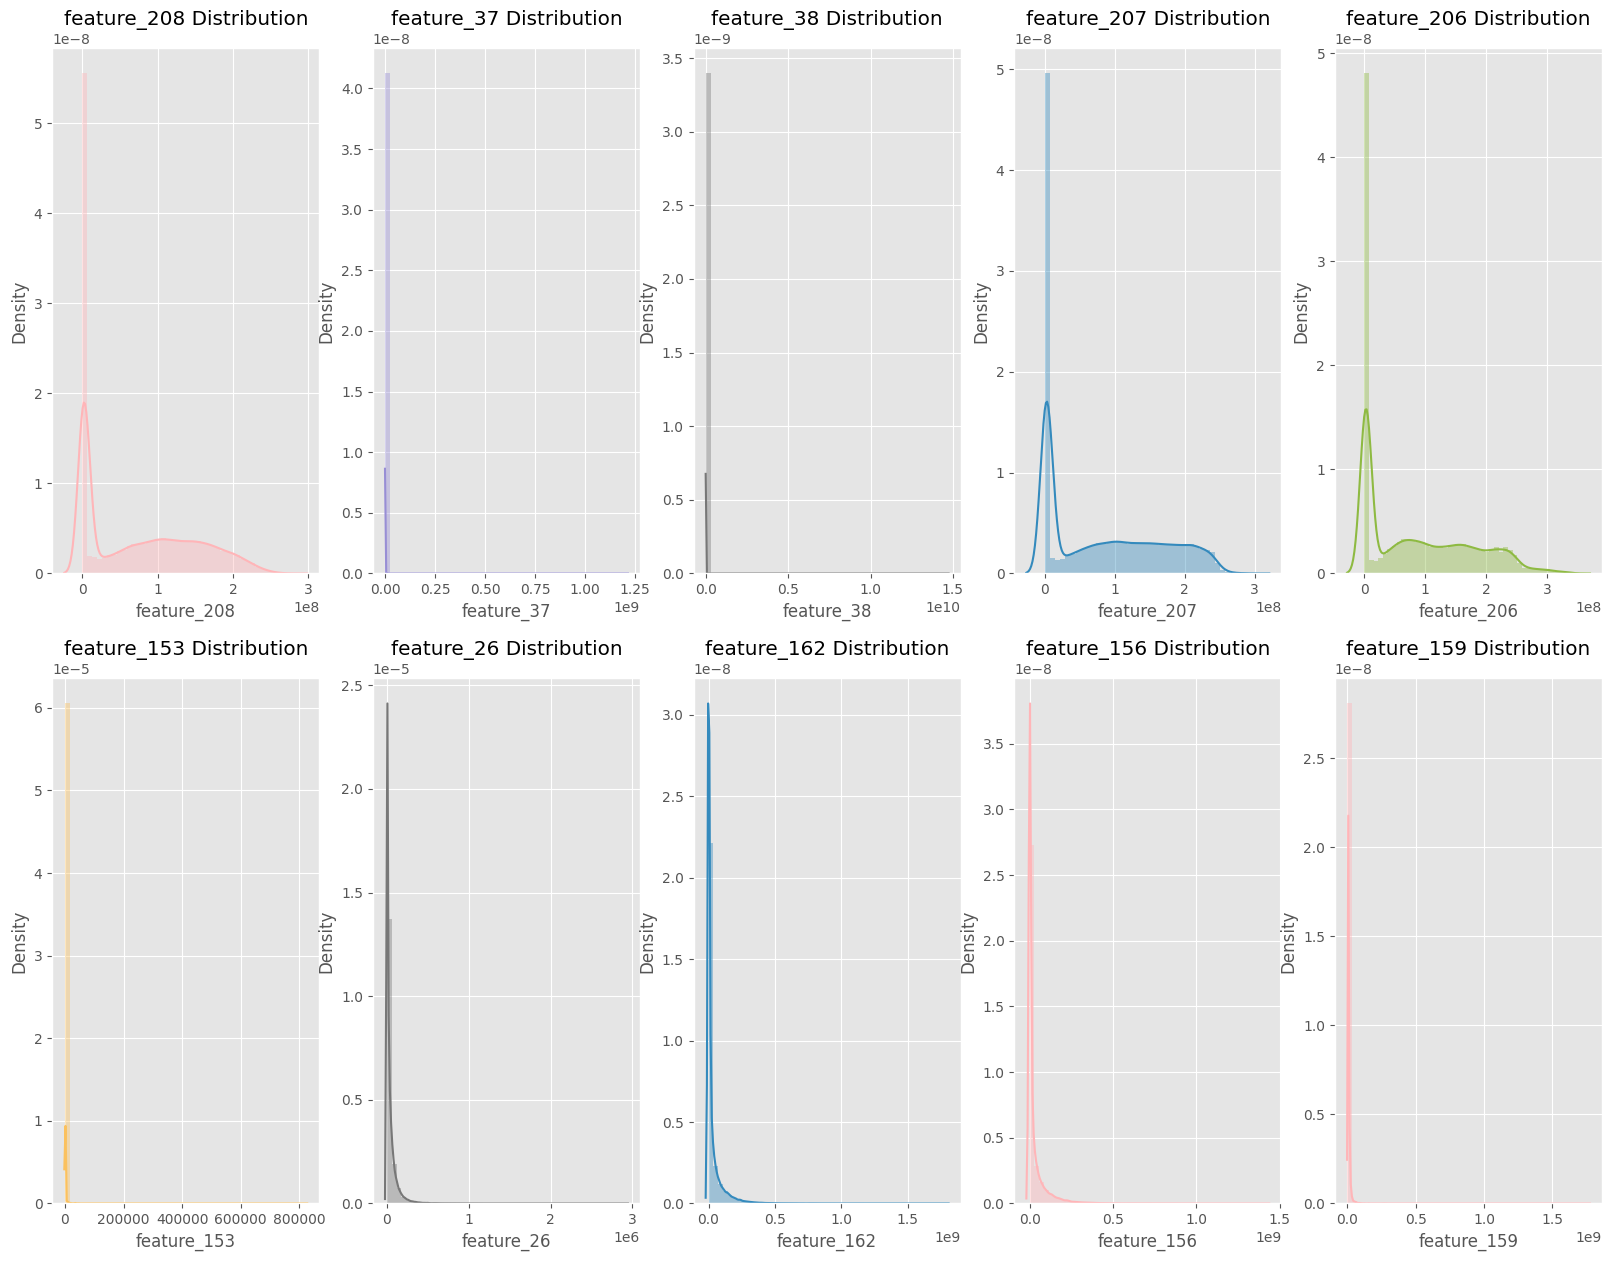

In [21]:
num_columns = [col for col in train_df.select_dtypes(['int', 'float']).columns if col not in drop_columns]
top10_columns =  train_df[num_columns].nunique().sort_values(ascending=False).index.values[:10]

fig, ax = plt.subplots(2,5, figsize=(20, 15))
for i, col in enumerate(top10_columns):
    sns.distplot(train_df[col], color = choice(color_pal), ax=ax[math.floor(i/5),i%5]).set_title(f'{col} Distribution')
fig.show()

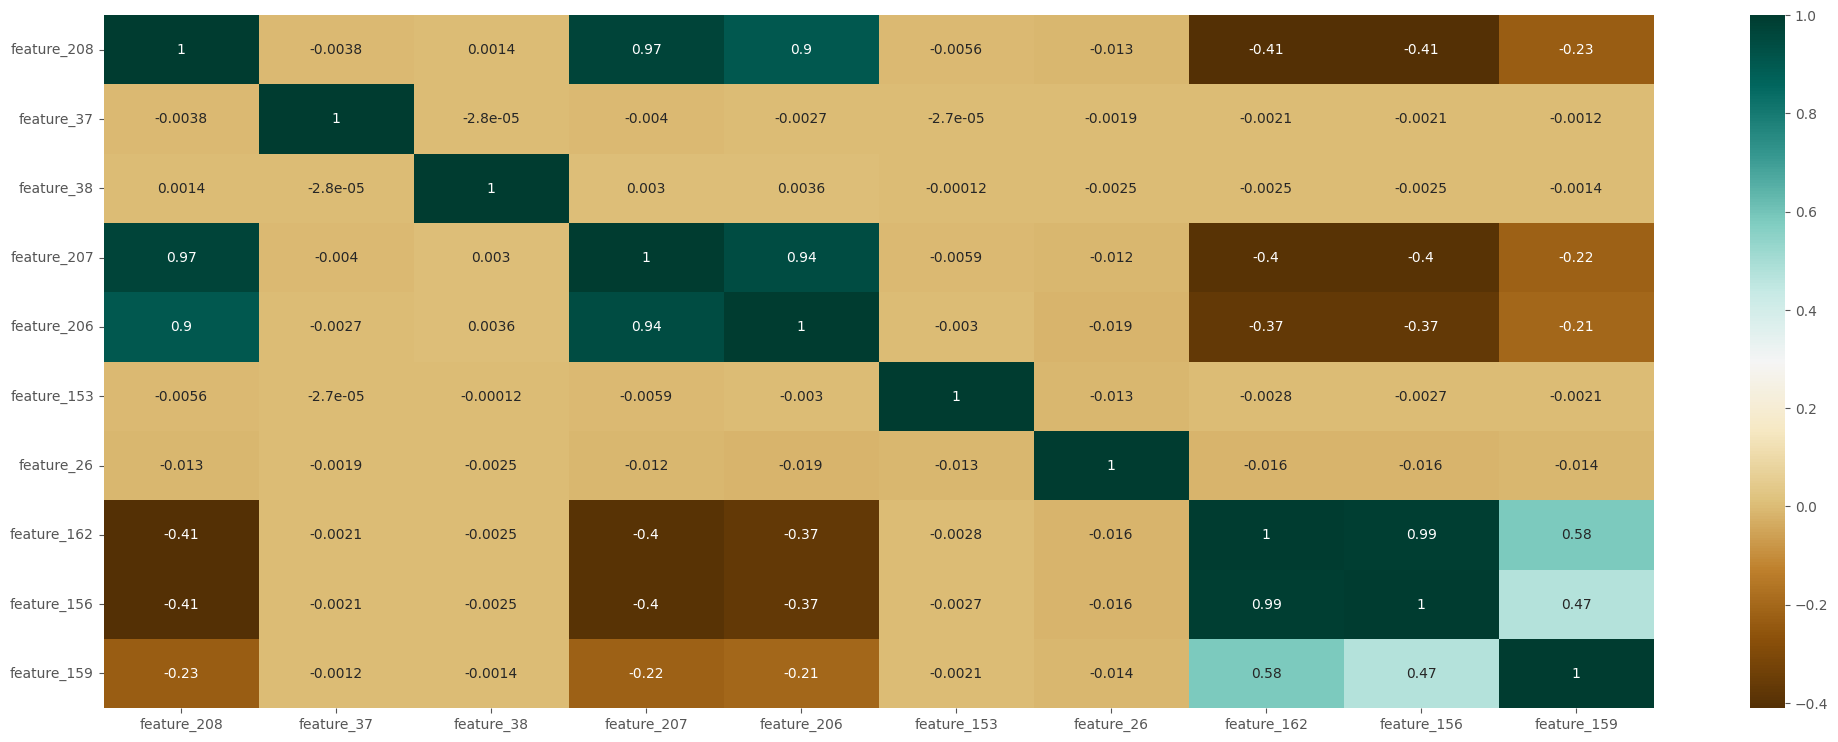

In [22]:
corr_df = train_df[top10_columns].corr()
plt.figure(figsize=(25, 9))
sns.heatmap(corr_df,annot=True ,cmap='BrBG');

In [23]:
corr_df = train_df[['target'] + num_columns].corr()
corr_df.head()

,target,feature_14,feature_15,feature_25,feature_26,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_98,feature_99,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_150,feature_151,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_245,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_372,feature_373,feature_374,feature_376,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_386,feature_387,feature_388,feature_390,feature_391,feature_392,feature_393,feature_394,feature_396,feature_398,feature_399,feature_400,feature_401,feature_402,feature_403,feature_404,feature_406,feature_407,feature_408,feature_410,feature_414,feature_415,feature_416,feature_417,feature_418,feature_420,feature_422,feature_423,feature_424,feature_426,feature_428,feature_429,feature_430,feature_431,feature_434,feature_435,feature_436,feature_437,feature_438,feature_439,feature_440,feature_441,feature_442,feature_443,feature_444,feature_446,feature_447,feature_448,feature_450,feature_452,feature_454,feature_456,feature_457,feature_458,feature_460,feature_462,feature_464,feature_466,feature_468,feature_470,feature_471,feature_473,feature_475,feature_477,feature_479,feature_481,feature_483,feature_485,feature_486,feature_488,feature_490,feature_

,target,feature_307,feature_297,feature_81,feature_108,feature_110,feature_82,feature_470,feature_264,feature_254,feature_263,feature_143,feature_298,feature_43,feature_169,feature_328,feature_48,feature_224,feature_354,feature_223,feature_353,feature_132,feature_118,feature_168,feature_268,feature_302,feature_402,feature_440,feature_369,feature_386,feature_430,feature_479,feature_492,feature_475,feature_494,feature_496,feature_497,feature_499,feature_444,feature_448,feature_450,feature_452,feature_454,feature_488,feature_506,feature_501,feature_503,feature_490,feature_477,feature_424,feature_426,feature_418,feature_420,feature_404,feature_408,feature_410,feature_394,feature_396,feature_481,feature_483,feature_458,feature_504,feature_462,feature_464,feature_466,feature_468,feature_485,feature_486,feature_384,feature_388,feature_374,feature_376,feature_471,feature_473,feature_460,feature_422,feature_392,feature_372,feature_446,feature_398,feature_406,feature_416,feature_438,feature_442,feature_428,feature_378,feature_434,feature_456,feature_136,feature_382,feature_390,feature_436,feature_267,feature_400,feature_414,feature_67,feature_131,feature_380,feature_128,feature_127,feature_381,feature_306,feature_305,feature_174,feature_122,feature_329,feature_129,feature_415,feature_348,feature_173,feature_79,feature_347,feature_172,feature_208,feature_26,feature_45,feature_206,feature_80,feature_73,feature_91,feature_93,feature_78,feature_25,feature_92,feature_87,feature_301,feature_245,feature_295,feature_137,feature_383,feature_140,feature_46,feature_104,feature_53,feature_403,feature_141,feature_207,feature_77,feature_130,feature_86,feature_435,feature_139,feature_125,feature_124,feature_391,feature_68,feature_218,feature_217,feature_265,feature_266,feature_320,feature_437,feature_352,feature_151,feature_309,feature_167,feature_366,feature_351,feature_304,feature_115,feature_147,feature_308,feature_365,feature_346,feature_66,feature_70,feature_345,feature_441,feature_236,feature_148,feature_65,feature_171,feature_235,feature_170,feature_300,feature_318,feature_370,feature_256,feature_260,feature_335,feature_126,feature_258,feature_296,feature_138,feature_99,feature_387,feature_294,feature_429,feature_182,feature_177,feature_60,feature_322,feature_101,feature_15,feature_257,feature_51,feature_156,feature_319,feature_162,feature_457,feature_85,feature_259,feature_166,feature_216,feature_14,feature_356,feature_215,feature_161,feature_44,feature_155,feature_368,feature_303,feature_261,feature_340,feature_160,feature_210,feature_339,feature_154,feature_255,feature_209,feature_181,feature_69,feature_96,feature_220,feature_212,feature_367,feature_342,feature_211,feature_142,feature_158,feature_355,feature_341,feature_226,feature_94,feature_74,feature_157,feature_222,feature_114,feature_439,feature_90,feature_95,feature_417,feature_253,feature_219,feature_399,feature_360,feature_72,feature_176,feature_221,feature_401,feature_111,feature_225,feature_184,feature_314,feature_159,feature_333,feature_119,feature_71,feature_299,feature_109,feature_359,feature_325,feature_61,feature_88,feature_323,feature_407,feature_331,feature_144,feature_179,feature_332,feature_39,feature_35,feature_84,feature_379,feature_49,feature_230,feature_117,feature_36,feature_334,feature_103,feature_310,feature_311,feature_229,feature_316,feature_349,feature_121,feature_150,feature_361,feature_443,feature_112,feature_324,feature_350,feature_373,feature_269,feature_40,feature_123,feature_344,feature_47,feature_146,feature_56,feature_57,feature_107,feature_89,feature_153,feature_38,feature_231,feature_175,feature_317,feature_447,feature_37,feature_362,feature_237,feature_178,feature_321,feature_238,feature_106,feature_363,feature_145,feature_393,feature_180,feature_214,feature_431,feature_105,feature_120,feature_343,feature_62,feature_50,feature_233,feature_183,feature_423,feature_213,feature_234,feature_326,feature_98,feature_330,feature_232,feature_63,feature_113,featu

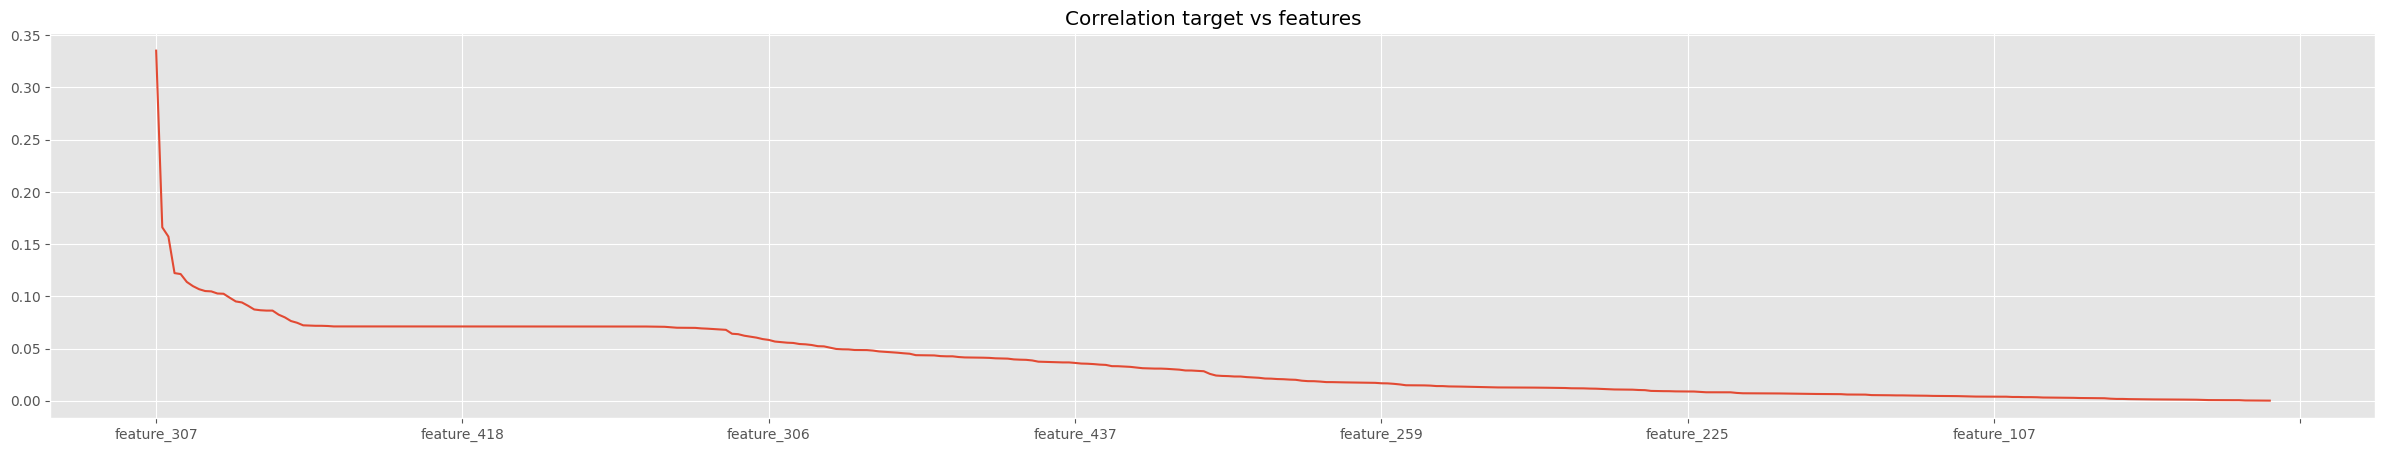

In [24]:
# Correlation with target
display(corr_df['target'].abs().sort_values(ascending=False).to_frame().T)
plt.figure(figsize=(30,5))

corr_df['target'].abs().sort_values(ascending=False).iloc[1:].plot()
plt.title("Correlation target vs features")
plt.show()

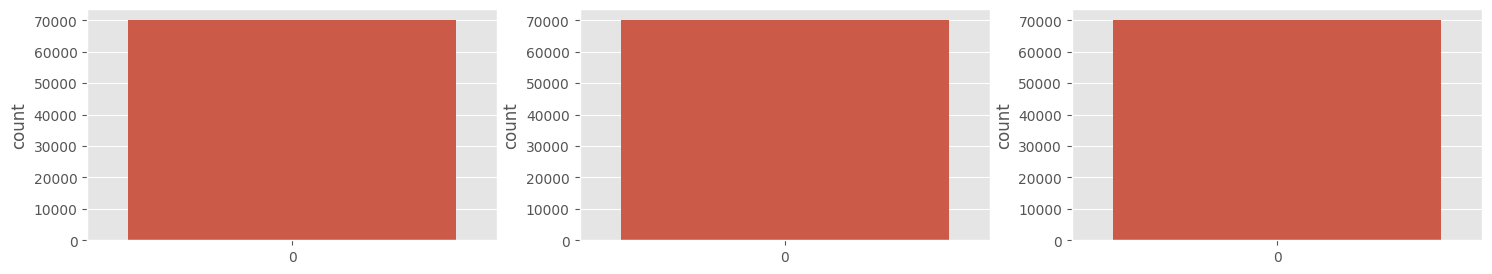

In [25]:
plt.figure(figsize=(18, 3))

# feature_307
plt.subplot(131)
sns.countplot(train_df['feature_307'])

# feature_297
plt.subplot(132)
sns.countplot(train_df['feature_297'])

# feature_297
plt.subplot(133)
sns.countplot(train_df['feature_81'])

plt.show()

In [26]:
from sklearn import preprocessing

def label_encoding(train_df, test_df, columns):
    for col in columns:
        le = preprocessing.LabelEncoder()
        values = pd.concat([train_df[col], test_df[col]], ignore_index=True)
        le.fit(values)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    return train_df, test_df

train_df, test_df = label_encoding(train_df, test_df, cat_columns)

In [27]:
target_col = 'target'
drop_cols = [target_col, 'id']
train_cols = [col for col in train_df.columns if col not in drop_cols]

X = train_df[train_cols]
y = train_df['target']
display(X.head())
display(y.head())

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_189,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_250,feature_251,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_376,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_386,feature_387,feature_388,feature_390,feature_391,featu

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

# optuna

In [28]:
# kfold
N_SPLITS = 5

# early stopping
ROUND = 300

# seed
SEEDS = np.arange(0, 10)

In [29]:
lgbm_params = {
    'objective': 'regression',
    'metric': 'auc',
    'n_estimators': 20000,
    'max_depth': 21,
    'learning_rate': 0.0014791220921706863,
    'reg_alpha': 4.759056097553685e-05,
    'reg_lambda': 0.0005697036258110147,
    'subsample_freq': 2,
    'subsample': 0.6033215840391701,
    'colsample_bytree': 0.897937949763288
}

# feature_importances
lgb_fimp = []
lgb_predictions = pd.DataFrame()
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=373)
cv_scores = np.empty(N_SPLITS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print('='*20, f'KFold={idx+1}', '='*20)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgbm.LGBMRegressor(random_state=SEEDS[idx], **lgbm_params)
    model.fit(X_train,
              y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='auc')
              #early_stopping_rounds = ROUND,
              #verbose = ROUND)

    fold_pred = model.predict(X_test)
    cv_scores[idx] = roc_auc_score(y_test, fold_pred)
    print(f"Fold={idx+1}, auc: {cv_scores[idx]:.6f}\n")
    
    # feature importance
    fim = pd.DataFrame(index=train_cols,
                 data=model.feature_importances_,
                 columns=[f'{idx}_importance'])
    lgb_fimp.append(fim)
    
    target_pred = model.predict(test_df[train_cols])
    lgb_predictions[f'fold{idx+1}'] = target_pred

print(f'mean_auc: {np.mean(cv_scores):.6f}')

==================== KFold=1 ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28847
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 440
[LightGBM] [Info] Start training from score 0.298196
Fold=1, auc: 0.792560

==================== KFold=2 ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28842
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 441
[LightGBM] [Info] Start training from score 0.298196
Fold=2, auc: 0.784128

==================== KFold=3 =========

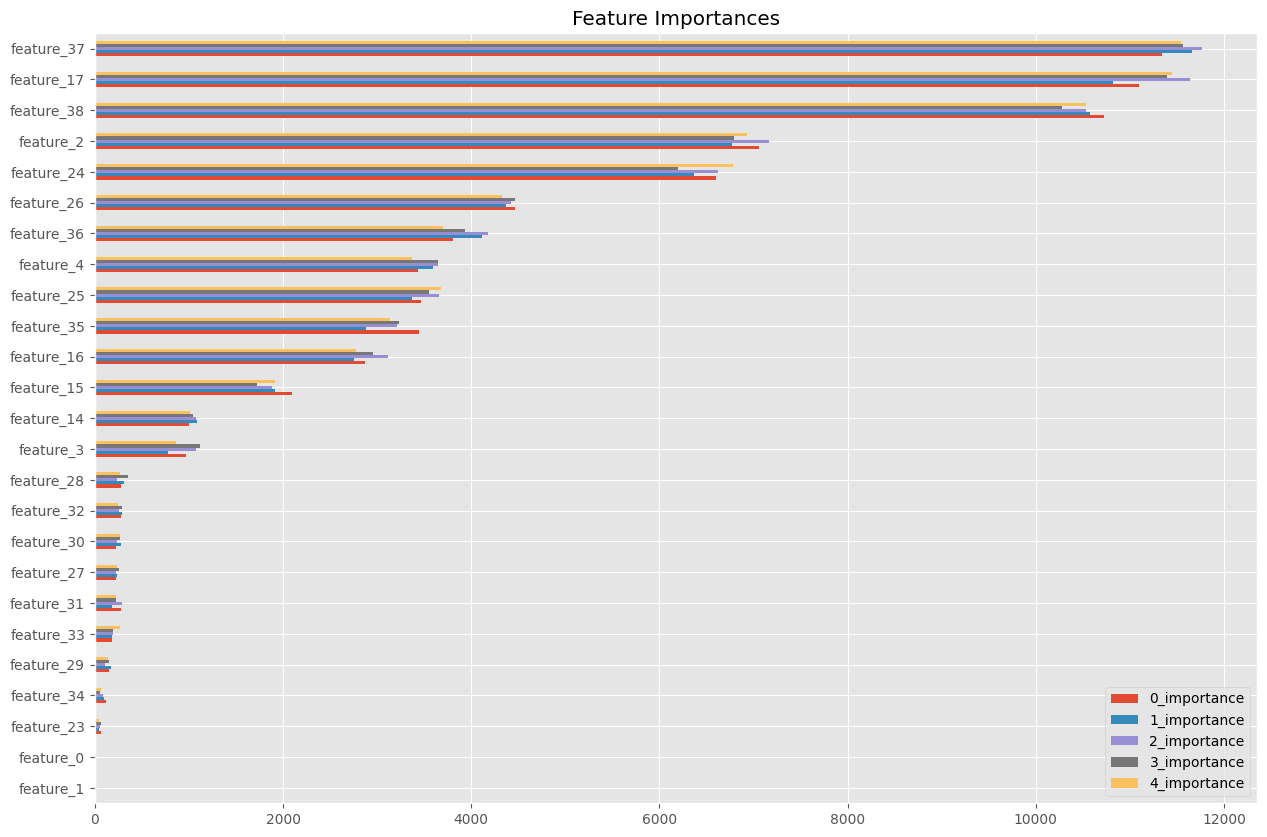

In [30]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(25)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importances')
plt.show()

,fold1,fold2,fold3,fold4,fold5,mean
0,0.456768,0.464402,0.437053,0.489708,0.334623,0.436696
1,0.310004,0.323364,0.294249,0.288471,0.353056,0.313764
2,0.308080,0.334421,0.332533,0.322665,0.314921,0.322506
3,0.131670,0.095793,0.102027,0.111634,0.106563,0.109588
4,0.240580,0.230735,0.240770,0.233285,0.232861,0.235662
...,...,...,...,...,...,...
29995,0.682051,0.642793,0.675767,0.629613,0.674314,0.660940
29996,0.337345,0.351797,0.341122,0.352758,0.346704,0.345924
29997,0.153360,0.156596,0.118633,0.157281,0.146484,0.146480
29998,0.637384,0.573864,0.667944,0.523399,0.630345,0.606640


<Axes: ylabel='Count'>

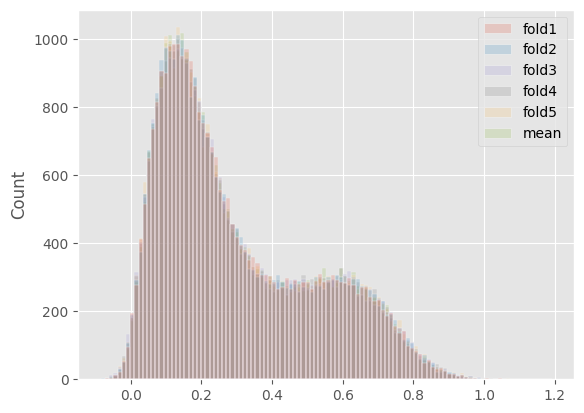

In [31]:
weights = [score/sum(cv_scores) for score in cv_scores]
lgb_predictions['mean'] =  np.average(lgb_predictions, axis=1, weights=weights)

display(lgb_predictions)
sns.histplot(lgb_predictions, alpha=0.2)

In [32]:
ss_df['target'] = lgb_predictions['mean']

In [33]:
del lgbm_fis_df, weights, model, train_df, test_df, X, y, corr_df
gc.collect()

36954

# Model Version2

In [1]:
!pip install optuna-integration[lightgbm] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 3.5 MB/s eta 0:00:00


In [2]:
!pip install xgboost -q

In [3]:
import gc
from math import sqrt
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score

import scipy.stats as ss
from scipy.stats import mode
import math as mt
from math import *
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import itertools
import random

In [4]:
df_train = pd.read_csv('../input/netflix-appetency/train.csv')
df_test = pd.read_csv('../input/netflix-appetency/test.csv')
df_sub = pd.read_csv('../input/netflix-appetency/sample_submission.csv')

In [5]:
obj_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print("obj_cols:   ", obj_cols)

drop_cols = []
binary_cols = []
for col in obj_cols:
    if df_train[col].nunique() <= 1:
        drop_cols.append(col)
    if df_train[col].nunique() == 2:
        binary_cols.append(col)
        
drop_cols = drop_cols + ['feature_198', 'feature_197', 'feature_196', 'feature_193', 'feature_83', 'feature_75', 'feature_76', 'feature_195', 'feature_5', 'feature_11', 'feature_8', 'feature_9', 'feature_12', 'feature_6', 'feature_10', 'feature_13', 'feature_7']
print("\ndrop_cols:     ", drop_cols)
len(obj_cols), len(binary_cols), len(drop_cols)

obj_cols:    ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_41', 'feature_42', 'feature_54', 'feature_55', 'feature_58', 'feature_97', 'feature_133', 'feature_134', 'feature_135', 'feature_152', 'feature_163', 'feature_164', 'feature_165', 'feature_185', 'feature_186', 'feature_187', 'feature_188', 'feature_189', 'feature_190', 'feature_191', 'feature_192', 'feature_194', 'feature_195', 'feature_199', 'feature_200', 'feature_201', 'feature_202', 'feature_203', 'feature_204', 'feature_205', 'feature_239', 'feature_240', 'feature_241', 'feature_242', 'feature_243', 'feature_244', 'feature_246', 'feature_247', 'feature_248', 'feature_249', 'feature_250', 'feature_251', 'feature_270', 'feature_271', 'feature_272', 'feature_273',

(92, 24, 23)

In [6]:
num_cols = df_train.select_dtypes(include=['int','float']).columns.tolist()

for col in num_cols:
    if df_train[col].nunique() <= 1:
        drop_cols.append(col)
    if df_train[col].nunique() == 2:
        binary_cols.append(col)
        
binary_cols.remove('target')
len(num_cols), len(binary_cols), len(drop_cols)

(417, 108, 80)

In [7]:
df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)
del drop_cols

In [8]:
df_train.head()

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,...,feature_490,feature_492,feature_494,feature_496,feature_497,feature_499,feature_501,feature_503,feature_504,feature_506
0,0,0,C0,C0,C1,C5,C11,0.0,0.000,C0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,C0,C0,C3,C5,C1,0.0,0.000,C2,...,0,0,0,0,0,0,0,0,0,0
2,2,0,C0,C0,C3,C5,C2,0.0,0.000,C1,...,0,0,0,0,0,0,0,0,0,0
3,3,0,C0,C0,C1,C5,C1,0.0,0.000,C0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,C0,C0,C3,C3,C11,0.0,0.258,C2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def basic_features(data, col):

    # Ensure the column is in datetime format
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime, coerce errors to NaT

    data[col+'year'] = data[col].dt.year
    data[col+'year'] = data[col+'year']-min(data[col+'year'])
    data[col+'month'] = data[col].dt.month
    data[col+'dayofweek'] = data[col].dt.dayofweek

    return data

def ddiff_features(data, col1, col2):
    # Convert date columns to datetime format
    data[col1] = pd.to_datetime(data[col1], errors='coerce', dayfirst=True)
    data[col2] = pd.to_datetime(data[col2], errors='coerce', dayfirst=True)
    
    # Check if both columns are datetime
    if not pd.api.types.is_datetime64_any_dtype(data[col1]) or not pd.api.types.is_datetime64_any_dtype(data[col2]):
        raise ValueError(f"Columns {col1} and {col2} must be datetime types.")
    
    # Calculate date differences
    data['MD_' + col1 + col2] = ((data[col1] - data[col2]) / np.timedelta64(1, 'm')).fillna(0).astype('Int64', errors='ignore')
    data['YD_' + col1 + col2] = ((data[col1] - data[col2]).dt.days / 365.25).fillna(0).astype('Int64', errors='ignore')  # Years
    data['DD_' + col1 + col2] = ((data[col1] - data[col2]) / np.timedelta64(1, 'D')).fillna(0).astype('Int64', errors='ignore')  # Use 'D' for days
    
    return data


In [16]:
# feature_191' ~ 'feature_204' are date_columns
dd_cols = ['feature_191', 'feature_192', 'feature_194', 'feature_195', 'feature_199', 'feature_200', 'feature_201', 'feature_202', 'feature_203', 'feature_204']
date_cols = [col for col in dd_cols if col in df_train.columns.tolist()]
date_cols

['feature_191',
 'feature_192',
 'feature_194',
 'feature_199',
 'feature_200',
 'feature_201',
 'feature_202',
 'feature_203',
 'feature_204']

In [17]:
before_ = df_train.shape[1]
print(before_)
for col in date_cols:
    df_train = basic_features(df_train, col)
    df_test = basic_features(df_test, col)
for i in range(0, len(date_cols)):
    for j in range(i + 1, len(date_cols)):
        df_train = ddiff_features(df_train, date_cols[i], date_cols[j])
        df_test = ddiff_features(df_test, date_cols[i], date_cols[j])

462


In [18]:
after_ = df_train.shape[1]

date_eng_cols = df_train.iloc[:,before_:after_].columns.tolist()
df_train = df_train.drop(date_cols, axis=1)
df_test = df_test.drop(date_cols, axis=1)
del date_cols

In [20]:
features = [col for col in df_train.columns.tolist() if col not in ['id', 'target']]

# Use pd.concat instead of append
combined_data = pd.concat([df_train[features], df_test[features]], ignore_index=True)
percent_missing = combined_data.isnull().sum() * 100 / (len(df_train) + len(df_test))

missing_value_df = pd.DataFrame({'column_name': features,
                                 'percent_missing': percent_missing})

missing_val_thresh = 40
drop_cols = missing_value_df[missing_value_df.percent_missing > missing_val_thresh]['column_name'].tolist()

df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

del drop_cols


In [ ]:
"""features = [col for col in df_train.columns.tolist() if col not in ['id','target']]

percent_missing = df_train[features].append(df_test[features]).isnull().sum() * 100 / (len(df_train) + len(df_test))
missing_value_df = pd.DataFrame({'column_name': df_train[features].columns,
                                 'percent_missing': percent_missing})

missing_val_thresh = 40
drop_cols = missing_value_df[missing_value_df.percent_missing>missing_val_thresh]['column_name'].tolist()

df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

del drop_cols"""

In [21]:
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist() + df_train.select_dtypes(include=['int','float']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in date_eng_cols]

col_cat_lt50_mt2 = []

for col in cat_cols:
    if col not in ['id','target']:
        if df_train[col].nunique()>2 and df_train[col].nunique()<50:
            col_cat_lt50_mt2.append(col)
            cat_cols.remove(col)
        
cat_cols = [col for col in df_train.select_dtypes(include=['object']).columns.tolist() if col not in binary_cols+col_cat_lt50_mt2]

len(cat_cols + binary_cols + col_cat_lt50_mt2), len(cat_cols), len(binary_cols), len(col_cat_lt50_mt2)

(244, 32, 108, 104)

In [ ]:
features = [col for col in df_train.columns.tolist() if col not in ['id','target'] + cat_cols + binary_cols + col_cat_lt50_mt2]

In [23]:
def add_stats(data, feats):
    
    before_ = data.shape[1]
    cols = feats
    data['f_min']   = data[cols].fillna(0).min(axis = 1)
    data['f_max']   = data[cols].fillna(0).max(axis = 1)
    data['f_mean']  = data[cols].fillna(0).mean(axis = 1)
    data['f_sd']    = data[cols].fillna(0).std(axis = 1)
    data['f_median']= data[cols].fillna(0).median(axis = 1)
    data['f_sum']   = data[cols].fillna(0).sum(axis = 1)

    after_ = data.shape[1]
    new_cols = data.iloc[:,before_:after_].columns.tolist()
    
    return data, new_cols

In [24]:
df_train, stat_cols = add_stats(df_train, [col for col in features if col not in date_eng_cols])
df_test = add_stats(df_test, [col for col in features if col not in date_eng_cols])[0]

features = features + stat_cols

In [25]:
X_train = df_train[cat_cols + binary_cols + col_cat_lt50_mt2 + features + ['target']].reset_index(drop=True)
X_test = df_test[cat_cols + binary_cols + col_cat_lt50_mt2 + features]
y_train = X_train['target']

In [26]:
params = {
        'objective': 'regression',
        'metric': 'auc',
        'max_depth': 21,
        'learning_rate': 0.0024791220921706863,
        'reg_alpha': 4.759056097553685e-05,
        'reg_lambda': 0.0005697036258110147,
        'subsample_freq': 2,
        'subsample': 0.6033215840391701,
        'colsample_bytree': 0.897937949763288,
        'verbose': -1,
        'subsample_for_bin': 1023
}

params_2 = {
        'boosting_type': 'gbdt', 
        'objective': 'binary', 
        'tree_learner': 'feature',
        'metric': 'AUC',
        'num_leaves': 31, 
        'max_depth': -1,
        'learning_rate': 0.006,
        'subsample_for_bin': 1023,
        'subsample_freq': 2,
        'min_child_samples': 511, 
        'reg_alpha': 0.85948, 
        'reg_lambda': 2.729,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'max_bin': 63,
}

In [33]:
import lightgbm as lgb
print(lgb.__version__)
!pip install --upgrade lightgbm -q
print(lgb.__version__)

4.6.0
4.6.0


In [29]:
for cc in tqdm(cat_cols + binary_cols + col_cat_lt50_mt2):
    fillna_const = 'MISSING_VALUE'
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train.loc[:, cc] = X_train[cc].astype('str').fillna(fillna_const)
    X_test.loc[:, cc] = X_test[cc].astype('str').fillna(fillna_const)
    X_train[cc] = X_train[cc].astype('category')
    X_test[cc] = X_test[cc].astype('category')
    
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

loss_function_name = 'auc'

NFOLD = 10
kf = StratifiedKFold(n_splits = NFOLD, shuffle=True, random_state = 1998)
kf_lr = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

100%|██████████| 244/244 [00:26<00:00,  9.26it/s]


In [40]:
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
import numpy as np
import lightgbm as lgb
from tqdm import tqdm

scores = []
p_valid = []
yp = []

for n_fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    
    # replace cat cols 
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True)
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True)
    X_test_temp = X_test.reset_index(drop=True)

    y_train_temp = X_train_temp['target'].values.ravel()  # 1차원 배열로 변환
    X_train_temp = X_train_temp.drop(['target'], axis=1)
    y_val_temp = X_val_temp['target'].values.ravel()  # 1차원 배열로 변환
    X_val_temp = X_val_temp.drop(['target'], axis=1)
    
    for cc in tqdm(binary_cols + col_cat_lt50_mt2 + cat_cols, disable=True):

        le = LabelEncoder()
        le.fit(list(set(X_test[cc]) | set(X_train[cc])))
        X_train_temp[cc] = le.transform(X_train_temp[cc])  # 1차원 배열로 변환
        X_val_temp[cc] = le.transform(X_val_temp[cc])  # 1차원 배열로 변환
        X_test_temp[cc] = le.transform(X_test_temp[cc])  # 1차원 배열로 변환
    
        lr = LinearRegression(n_jobs=-1)
        ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')  # handle_unknown='ignore' 추가
        
        #ohe.fit(np.arange(len(le.classes_)).reshape(-1, 1))
        ohe.fit(X_train_temp[[cc]])  # 수정된 부분
        x_ohe_train = ohe.transform(X_train_temp[[cc]])
        x_ohe_val = ohe.transform(X_val_temp[[cc]])
        x_ohe_test = ohe.transform(X_test_temp[[cc]])

        lr.fit(x_ohe_train, y_train_temp)
    
        X_train_temp[cc] = cross_val_predict(lr, x_ohe_train, y_train_temp, cv=kf_lr, n_jobs=-1)
        X_val_temp[cc] = lr.predict(x_ohe_val)
        X_test_temp[cc] = lr.predict(x_ohe_test)
               
    print('X_train shape:', X_train_temp.shape)
    print('X_valid shape:', X_val_temp.shape)
        
    lgb_data_train = lgb.Dataset(X_train_temp, 
                                 label=y_train_temp,
                                 free_raw_data=False)

    lgb_data_valid = lgb.Dataset(X_val_temp, 
                                 label=y_val_temp,
                                 free_raw_data=False,
                                 reference=lgb_data_train)
    lgb_model = lgb.train(params, 
                      lgb_data_train, 
                      valid_sets = [lgb_data_train, lgb_data_valid],
                      #early_stopping_rounds = 150,
                      num_boost_round = 6000)
        
    y_hat_valid_lgb = lgb_model.predict(X_val_temp)
    y_hat_test_lgb = lgb_model.predict(X_test_temp)
        
    lgb_data_train = lgb.Dataset(X_train_temp, 
                                 label=y_train_temp,
                                 free_raw_data=True)

    lgb_data_valid = lgb.Dataset(X_val_temp, 
                                 label=y_val_temp,
                                 free_raw_data=True,
                                 reference=lgb_data_train)
    
    lgb_model_2 = lgb.train(params_2, 
                      lgb_data_train, 
                      valid_sets = [lgb_data_train, lgb_data_valid],
                      #verbose_eval = 0,
                      #early_stopping_rounds = 150,
                      num_boost_round = 6000)
    
   

0it [00:00, ?it/s]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


1it [07:16, 436.37s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


2it [15:14, 460.82s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


3it [23:19, 472.08s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


4it [31:03, 468.64s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


5it [38:39, 464.24s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


6it [46:44, 471.38s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


7it [54:24, 467.65s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


8it [1:02:29, 473.20s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


9it [1:10:07, 468.39s/it]

X_train shape: (63000, 535)
X_valid shape: (7000, 535)


10it [1:18:16, 469.63s/it]


In [45]:
y_hat_valid_lgb = lgb_model.predict(X_val_temp)
y_hat_test_lgb = lgb_model.predict(X_test_temp)
    
yp.append(y_hat_test_lgb)
yp

[array([0.33672333, 0.37893142, 0.32032412, ..., 0.17643936, 0.54219151,
        0.09345939]),
 array([0.33672333, 0.37893142, 0.32032412, ..., 0.17643936, 0.54219151,
        0.09345939])]

In [47]:
score = np.sqrt(np.mean((y_hat_valid_lgb - y_val_temp) ** 2))  # RMSE 계산
scores.append(score)


print("Average score:", sum(scores) / len(scores))
print("Scores for each fold:", scores)


Average score: 0.40629784857345264
Scores for each fold: [0.40629784857345264]


In [48]:
from scipy.stats.mstats import gmean
subm = pd.DataFrame()
subm['id'] = df_test['id']
subm['target'] = pd.DataFrame(sum(yp)/NFOLD)

In [51]:
#df_sub = pd.read_csv('../input/netflix-appetency/sample_submission.csv')

subm = subm.sort_values('id').reset_index(drop=True)
ss_df = df_sub.sort_values('id').reset_index(drop=True)

sub = pd.DataFrame()
sub['id'] = subm['id']
sub['target'] = (subm['target'] + ss_df['target'])/2.

In [52]:
filename = 'submission.csv'
sub.to_csv(filename, index=False)